In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. 数据预处理
def load_data(data_path):
    df = pd.read_csv(data_path)  # 替换为您的数据集路径
    X = df.iloc[:, :-1].values  # 特征向量
    y = df.iloc[:, -1].values  # 标签

    # 标准化特征向量
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data(r'C:\Users\MYZ\PycharmProjects\毕设实验\数据.csv')  # 替换为您的数据集路径

# 2. 定义自定义数据集类
class FeatureDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx] if self.y is not None else None

        if self.transform:
            x = self.transform(x)

        if y is not None:
            return x, y
        else:
            return x

# 3. 定义模型
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(np.unique(y_train))  # 假设标签是离散的，根据实际情况调整
model = MLP(input_dim, hidden_dim, output_dim)

# 4. 定义损失函数
def cross_entropy_loss(model, x, y):
    y_pred = model(x)
    return nn.CrossEntropyLoss()(y_pred, y)

# 5. 定义训练函数
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = cross_entropy_loss(model, inputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

# 6. 设置设备和数据加载器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = FeatureDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FeatureDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 7. 训练模型
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')

# 8. 评估模型（可选）
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1, Train Loss: 0.3095
Epoch 2, Train Loss: 0.1372
Epoch 3, Train Loss: 0.0754
Epoch 4, Train Loss: 0.0445
Epoch 5, Train Loss: 0.0213
Epoch 6, Train Loss: 0.0156
Epoch 7, Train Loss: 0.0091
Epoch 8, Train Loss: 0.0035
Epoch 9, Train Loss: 0.0023
Epoch 10, Train Loss: 0.0017
Epoch 11, Train Loss: 0.0013
Epoch 12, Train Loss: 0.0011
Epoch 13, Train Loss: 0.0009
Epoch 14, Train Loss: 0.0008
Epoch 15, Train Loss: 0.0007
Epoch 16, Train Loss: 0.0006
Epoch 17, Train Loss: 0.0005
Epoch 18, Train Loss: 0.0005
Epoch 19, Train Loss: 0.0004
Epoch 20, Train Loss: 0.0004
Epoch 21, Train Loss: 0.0003
Epoch 22, Train Loss: 0.0003
Epoch 23, Train Loss: 0.0003
Epoch 24, Train Loss: 0.0003
Epoch 25, Train Loss: 0.0002
Epoch 26, Train Loss: 0.0002
Epoch 27, Train Loss: 0.0002
Epoch 28, Train Loss: 0.0002
Epoch 29, Train Loss: 0.0002
Epoch 30, Train Loss: 0.0002
Epoch 31, Train Loss: 0.0002
Epoch 32, Train Loss: 0.0001
Epoch 33, Train Loss: 0.0001
Epoch 34, Train Loss: 0.0001
Epoch 35, Train Loss: 0

In [2]:
from sklearn.model_selection import StratifiedKFold

# 定义交叉验证
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 交叉验证评估
cv_scores = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

    # 重新创建数据集和加载器
    train_fold_dataset = FeatureDataset(X_train_cv, y_train_cv)
    val_fold_dataset = FeatureDataset(X_val_cv, y_val_cv)
    train_loader_fold = DataLoader(train_fold_dataset, batch_size=64, shuffle=True)
    val_loader_fold = DataLoader(val_fold_dataset, batch_size=64, shuffle=False)

    # 重置模型和优化器
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练和验证
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader_fold, optimizer, device)
        # 这里可以添加验证逻辑，例如计算验证集上的损失或准确率
        # 注意，这里简化了代码，实际应包括验证逻辑

    # 在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_outputs = [model(inputs.to(device)) for inputs, _ in val_loader_fold]
        val_outputs = torch.cat(val_outputs)
        _, val_preds = torch.max(val_outputs, 1)
        y_val_cv_tensor = torch.tensor(y_val_cv, dtype=torch.long, device=val_preds.device)
        correct = torch.eq(val_preds.cpu(), y_val_cv_tensor.cpu()).float()
        val_acc = correct.mean()
    cv_scores.append(val_acc)
    print(f'Fold {fold+1} Validation Accuracy: {val_acc:.4f}')

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.4f}')

Fold 1 Validation Accuracy: 0.9710
Fold 2 Validation Accuracy: 0.9673
Fold 3 Validation Accuracy: 0.9622
Fold 4 Validation Accuracy: 0.9647
Fold 5 Validation Accuracy: 0.9596
Cross-Validation Scores: [tensor(0.9710), tensor(0.9673), tensor(0.9622), tensor(0.9647), tensor(0.9596)]
Mean CV Accuracy: 0.9650


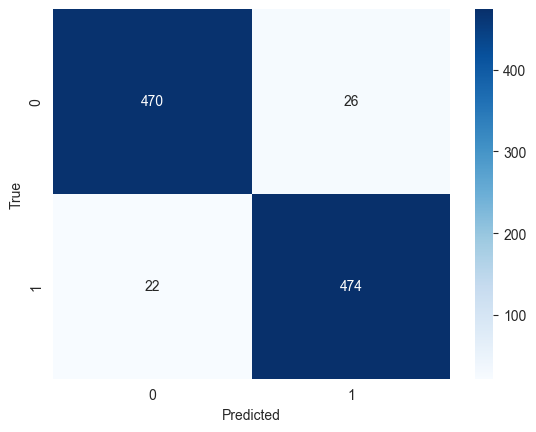

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 在测试集上计算混淆矩阵
model.eval()
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

conf_mat = confusion_matrix(y_test, all_preds)

# 可视化混淆矩阵
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

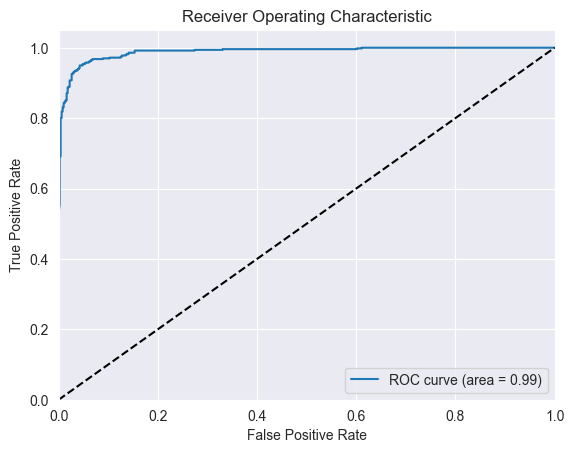

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 假设二分类问题，且标签已转换为0/1
y_test_binary = (y_test == np.unique(y_test)[1]).astype(int)

# 获取概率预测
model.eval()
probs = torch.softmax(model(torch.tensor(X_test, dtype=torch.float32).to(device)), dim=1)[:, 1].detach().cpu().numpy()

fpr, tpr, _ = roc_curve(y_test_binary, probs)
roc_auc = auc(fpr, tpr)

plt.figure(facecolor='white')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9516
